<a href="https://colab.research.google.com/github/Bandi120424/Sentiment-Anlaysis/blob/main/text%26audio_%EB%A5%BC_%EC%9D%B4%EC%9A%A9%ED%95%9C_%ED%95%9C%EA%B5%AD%EC%96%B4_%EA%B0%90%EC%A0%95_%EB%B6%84%EB%A5%98_%EB%AA%A8%EB%8D%B8_230120.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 감정 분류 모델 
- 데이터셋: AI-Hub 감정 분류를 위한 음성 데이터셋 
- 참고문헌
  - https://www.kaggle.com/code/shivamburnwal/speech-emotion-recognition
  - https://librosa.org/doc/main/feature.html
  - https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html


### 라이브러리 임포트

In [ ]:
pip install sentence_transformers

In [2]:
import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import dot
from numpy.linalg import norm
import seaborn as sns
import matplotlib.pyplot as plt
import urllib.request

import librosa
import librosa.display
from IPython.display import Audio

한글 폰트 설치

In [2]:
!apt -qq -y install fonts-nanum > /dev/null

In [5]:
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf' #나눔고딕설치
font = fm.FontProperties(fname=fontpath, size=9)
fm._rebuild()

# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'

# Colab 의 한글 폰트 설정
plt.rc('font', family='NanumBarunGothic') 

In [6]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


### 데이터 로드 및 병합

In [22]:
txt_data = pd.read_csv("./5차년도.csv", encoding= 'CP949')

In [8]:
print(f"txt_data 길이: {len(txt_data)}")
print(f"txt_data shape: {txt_data.shape}")

txt_data 길이: 10011
txt_data shape: (10011, 15)


In [9]:
txt_data.head(2)

,wav_id,발화문,상황,1번 감정,1번 감정세기,2번 감정,2번 감정세기,3번 감정,3번 감정세기,4번 감정,4번감정세기,5번 감정,5번 감정세기,나이,성별
0,5ed10dbc2880d70f286121c3,개를 예쁘다고 사놓고 끝까지 키우지도 않고 버리는 사람들이 엄청 많아졌대.,disgust,Angry,2,Angry,2,Angry,2,Angry,2,Angry,2,33,female
1,5ecb60ef9aa8ea0eec53edb1,지금도 그대로 있어. 치우는 사람이 없어.,disgust,Neutral,0,Disgust,2,Sadness,2,Disgust,2,Disgust,1,48,female


#### 결측치 확인

In [ ]:
txt_data.isnull().sum()

wav_id     0
발화문        0
상황         0
1번 감정      0
1번 감정세기    0
2번 감정      0
2번 감정세기    0
3번 감정      0
3번 감정세기    0
4번 감정      0
4번감정세기     0
5번 감정      0
5번 감정세기    0
나이         0
성별         0
dtype: int64

## EDA 

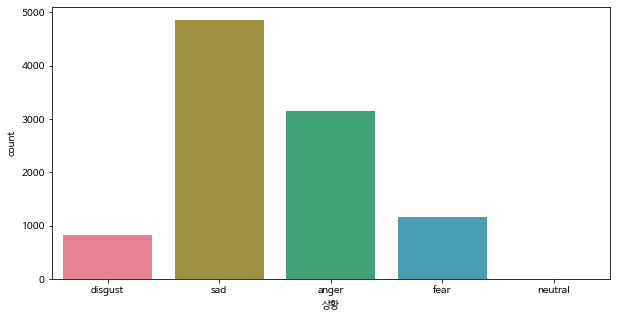

In [6]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.countplot(x = txt_data['상황'], palette = "husl",  ax = ax)
plt.show()

#### 감정세기 라벨 알아보기

In [ ]:
sad_data = txt_data[txt_data['상황'] == 'sad']
sad_data.head(5)

텍스트만 관찰했을 때는, 1-5번 감정에서 제일 많이 등장하는 감정을 최종 label이라고 생각하는 것이 합리적이므로, data 마다 1-5번 감정과 각 감정의 세기를 고려하고 최종 label을 새로 달아준다.

그런데, 1-5번 감정의 label을 살펴보면 일부 label은 형식이 통일되어있지 않은 것을 확인할 수 있다. 
따라서, lowercase로 label 형식을 통일해준다.

In [7]:
txt_data['1번 감정'] = txt_data['1번 감정'].apply(str.lower)
txt_data['2번 감정'] = txt_data['2번 감정'].apply(str.lower)
txt_data['3번 감정'] = txt_data['3번 감정'].apply(str.lower)
txt_data['4번 감정'] = txt_data['4번 감정'].apply(str.lower)
txt_data['5번 감정'] = txt_data['5번 감정'].apply(str.lower)

In [8]:
labels = txt_data['5번 감정'].unique().tolist()
labels

['angry', 'disgust', 'sadness', 'fear', 'surprise', 'neutral', 'happiness']

In [14]:
labels = txt_data['상황'].unique().tolist()
labels

['disgust', 'sad', 'anger', 'fear', 'neutral']

In [ ]:
sentiments = {x:0 for x in labels}
sentiments

{'angry': 0,
 'disgust': 0,
 'sadness': 0,
 'fear': 0,
 'surprise': 0,
 'neutral': 0,
 'happiness': 0}

In [9]:
def get_keys(dic): #returns a key for max values in dic
  key_list = list(dic.keys())
  val_list = list(dic.values())
  pos = val_list.index(max(val_list))
  return key_list[pos]

In [15]:
final_label = []
for i in range(len(txt_data)):
  sentiments = {'angry':0, 'sadness':0, 'happiness':0, 'fear': 0, 'disgust':0, 'surprise':0, 'neutral':0}
  sentiments[txt_data.iloc[i]['1번 감정']] += txt_data.iloc[i]['1번 감정세기']
  sentiments[txt_data.iloc[i]['2번 감정']] += txt_data.iloc[i]['2번 감정세기']
  sentiments[txt_data.iloc[i]['3번 감정']] += txt_data.iloc[i]['3번 감정세기']
  sentiments[txt_data.iloc[i]['4번 감정']] += txt_data.iloc[i]['4번감정세기']
  sentiments[txt_data.iloc[i]['5번 감정']] += txt_data.iloc[i]['5번 감정세기']

  final_label.append(get_keys(sentiments))

In [36]:
final_label_df = pd.DataFrame(final_label, columns=['final_label'])
new_txt_data = pd.concat([txt_data[['wav_id', '발화문']], final_label_df], axis = 1)

In [37]:
new_txt_data.head(2)

,wav_id,발화문,final_label
0,5ed10dbc2880d70f286121c3,개를 예쁘다고 사놓고 끝까지 키우지도 않고 버리는 사람들이 엄청 많아졌대.,angry
1,5ecb60ef9aa8ea0eec53edb1,지금도 그대로 있어. 치우는 사람이 없어.,disgust


final_label로 분포를 다시 살펴보자

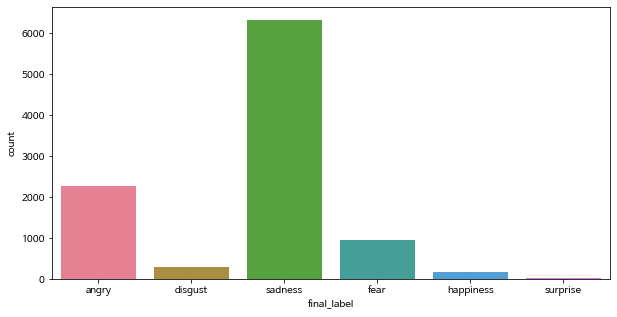

In [24]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.countplot(x = new_txt_data['final_label'], palette = "husl",  ax = ax)
plt.show()

In [ ]:
#txt_data.to_csv('merged_data_with_label')

## 훈련에 이용할 음성 데이터 선택

### 압축 해제 및 일부 데이터 추출

In [ ]:
# %cd /Data
# !zip -FFv '/Data/year5.zip' --out 'Data/year5_audio.zip'
# !unzip -qq 'Data/year5_audio.zip'

In [41]:
audio_path = './5차년도_wav'
wav_list = os.listdir(audio_path)
wav_list_tmp = random.sample(wav_list, 1000) #colab 용량 한계로 1000개만 

In [42]:
wav_list_tmp [:2]

['5f0d392bb140144dfcff3408.wav', '5f032421b140144dfcfede97.wav']

In [44]:
wav_list_tmp_id = [] #wav 파일명에서 .wav 제외하고 순수한 wav_id를 추출 
for i in range(1000):
    wav_list_tmp_id.append(wav_list_tmp[i][:-4])

wav_list_tmp_label, wav_list_tmp_sentence = [], []
for x in wav_list_tmp_id:
  wav_list_tmp_label.append(new_txt_data[new_txt_data['wav_id'] == x]['final_label'].values[0]) 
  wav_list_tmp_sentence.append(new_txt_data[new_txt_data['wav_id'] == x]['발화문'].values[0]) 

In [47]:
wav_df = pd.DataFrame(
    {'wav_id': wav_list_tmp_id,
     'final_label': wav_list_tmp_label,
     'sentence': wav_list_tmp_sentence
    })

In [45]:
wav_df.head(3)

,wav_id,label,sentence
0,5f0d392bb140144dfcff3408,sadness,아니. 너무 잘해줘서 정말 잘 맞았거든.
1,5f032421b140144dfcfede97,sadness,알았어. 오늘처럼 힘들 때 내 이야기 좀 들어줘. 그럼 많이 풀릴 것 같애.
2,5f01d0bab140144dfcfecf1f,fear,내가 먼저 만나자고 한 약속이라서 내가 먼저 미루기에는 좀 그래.\t


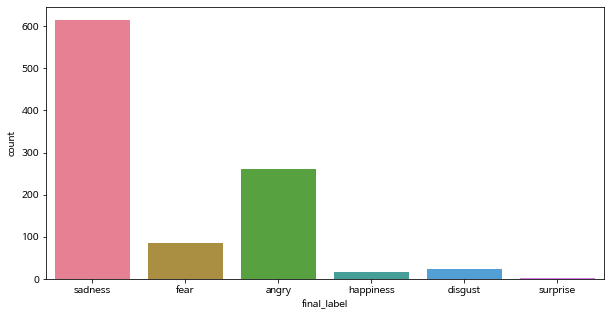

In [48]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.countplot(x = wav_df['final_label'], palette = "husl",  ax = ax)
plt.show()

In [ ]:
wav_df.isnull().sum()

wav_id      0
label       0
sentence    0
dtype: int64

### 데이터 augmentation 및 특징 벡터 추출

In [49]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

In [50]:
def extract_features(data, sample_rate):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

In [51]:
def get_features(path):
    
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.0)
    
    # without augmentation
    res1 = extract_features(data, sample_rate)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data, sample_rate)
    result = np.concatenate((result, res2), axis = 0) 

    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch, sample_rate)
    result = np.concatenate((result, res3), axis = 0) 

    return result

In [52]:
X_audio, Y = [], []
for path, label in zip(wav_df['wav_id'], wav_df['final_label']):
    audio_features = get_features(audio_path+'/'+path+'.wav')
    X_audio.append(audio_features)
    Y.append(label)

In [54]:
audio_features = pd.DataFrame(X_audio)
final_df = pd.concat([audio_features, wav_df[['wav_id', 'final_label', 'sentence']]], axis = 1)
final_df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,479,480,481,482,483,484,485,wav_id,final_label,sentence
0,0.066578,0.447292,0.460067,0.440434,0.453078,0.475702,0.564345,0.668742,0.654668,0.603272,...,0.000008,0.000005,0.000004,0.000003,0.000001,8.742476e-08,1.320669e-09,5f0d392bb140144dfcff3408,sadness,아니. 너무 잘해줘서 정말 잘 맞았거든.
1,0.071899,0.558107,0.431963,0.389947,0.388274,0.431069,0.418731,0.427488,0.426972,0.527539,...,0.000022,0.000006,0.000010,0.000006,0.000002,3.366798e-07,2.743565e-09,5f032421b140144dfcfede97,sadness,알았어. 오늘처럼 힘들 때 내 이야기 좀 들어줘. 그럼 많이 풀릴 것 같애.
2,0.034469,0.581322,0.544015,0.581927,0.563149,0.475744,0.474417,0.548441,0.576161,0.605653,...,0.000009,0.000011,0.000012,0.000007,0.000002,1.748744e-07,3.997895e-08,5f01d0bab140144dfcfecf1f,fear,내가 먼저 만나자고 한 약속이라서 내가 먼저 미루기에는 좀 그래.\t


## 텍스트 데이터 => embedding vector 
**references**
- https://www.sbert.net/docs/pretrained_models.html
- https://huggingface.co/models?library=sentence-transformers&sort=downloads&search=ko

**performance**
- Pre-trained Model: 'sentence-transformers/xlm-r-100langs-bert-base-nli-stsb-mean-tokens': 
  - Test Accuracy:  0.7319999933242798
- Pre-trained Model: 'sentence-transformers/multi-qa-distilbert-cos-v1'
  - Test Accuracy:  0.6320000290870667
- Pre-trained Model: 'jhgan/ko-sroberta-multitask'
  - Test Accuracy:  0.7239999771118164
- Pre-trained Model:  all-distilroberta-v1
  - Test Accuracy:  0.6639999747276306
- Pre-trained Model:  jhgan/ko-sbert-multitask
  - Test Accuracy:  0.7680000066757202
- Pre-trained Model:  all-MiniLM-L12-v2
  - Test Accuracy:  0.6359999775886536
- Pre-trained Model:  jhgan/ko-sroberta-sts
  - Test Accuracy:  0.7599999904632568

In [61]:
class text_embedding():
  def __init__(self, model_name):
    self.model_name = model_name

  def fit(self, X, y=None):
        return self
  
  def transform(self, X):
        embedding_model = SentenceTransformer(self.model_name)
        embedding_vec = embedding_model.encode(X['sentence'])
        X_val = np.concatenate((X.drop(['final_label', 'wav_id', 'sentence'], axis = 1), embedding_vec), axis = 1)
        return X_val

In [56]:
from sentence_transformers import SentenceTransformer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

In [57]:
scaler = StandardScaler()
encoder = OneHotEncoder()

## 모델링
마지막 dense layer의 units = 감정 label의 갯수 임에 주의
현재 감정 label은 6개

In [58]:
def custom_model(x_train):
  model=Sequential()
  model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
  model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

  model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
  model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

  model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
  model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
  model.add(Dropout(0.2))

  model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
  model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

  model.add(Flatten())
  model.add(Dense(units=32, activation='relu'))
  model.add(Dropout(0.3))

  model.add(Dense(units=6, activation='softmax'))
  model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

  #model.summary()
  return model

In [59]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001) #learning rate 조절 

### 여러 pre-trained model에 대하여 훈련

In [63]:
pre_trained_models = ['sentence-transformers/xlm-r-100langs-bert-base-nli-stsb-mean-tokens',
'sentence-transformers/multi-qa-distilbert-cos-v1',
'jhgan/ko-sroberta-multitask',
'all-distilroberta-v1',
'jhgan/ko-sbert-multitask',
'all-MiniLM-L12-v2', 'jhgan/ko-sroberta-sts']


Y = final_df['final_label'].values
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

for i in pre_trained_models:
  txt_embed = text_embedding(model_name = i)
  X = txt_embed.transform(final_df)

  x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
  x_train = scaler.fit_transform(x_train)
  x_test = scaler.transform(x_test)

  x_train = np.expand_dims(x_train, axis=2)
  x_test = np.expand_dims(x_test, axis=2)
  x_train.shape, y_train.shape, x_test.shape, y_test.shape

  model = custom_model(x_train)
  history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

  test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
  print("Pre-trained Model: ", i)
  print("Test Accuracy: ",test_acc)

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/573 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/134M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/352 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Epoch 1/50
12/12 [==============================] - 3s 150ms/step - loss: 1.3949 - accuracy: 0.5173 - val_loss: 1.0868 - val_accuracy: 0.6480 - lr: 0.0010
Epoch 2/50
12/12 [==============================] - 0s 37ms/step - loss: 1.2866 - accuracy: 0.5373 - val_loss: 1.1539 - val_accuracy: 0.6480 - lr: 0.0010
Epoch 3/50
12/12 [==============================] - 0s 38ms/step - loss: 1.2329 - accuracy: 0.5413 - val_loss: 1.1419 - val_accuracy: 0.6440 - lr: 0.0010
Epoch 4/50
12/12 [==============================] - 0s 37ms/step - loss: 1.1919 - accuracy: 0.5520 - val_loss: 1.1762 - val_accuracy: 0.6360 - lr: 0.0010
Epoch 5/50
12/12 [==============================] - 0s 37ms/step - loss: 1.1141 - accuracy: 0.5627 - val_loss: 1.1208 - val_accuracy: 0.6280 - lr: 0.0010
Epoch 6/50
12/12 [==============================] - 0s 37ms/step - loss: 1.1258 - accuracy: 0.5840 - val_loss: 1.1630 - val_accuracy: 0.5920 - lr: 0.0010
Epoch 7/50
12/12 [==============================] - 0s 37ms/step - loss: 1.

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.00k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/744 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/123 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/923 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/443M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/302 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/156 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/495k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/585 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/248k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Epoch 1/50
12/12 [==============================] - 2s 121ms/step - loss: 1.2171 - accuracy: 0.5280 - val_loss: 1.1877 - val_accuracy: 0.6160 - lr: 0.0010
Epoch 2/50
12/12 [==============================] - 1s 52ms/step - loss: 1.1266 - accuracy: 0.5867 - val_loss: 1.2125 - val_accuracy: 0.6160 - lr: 0.0010
Epoch 3/50
12/12 [==============================] - 1s 53ms/step - loss: 1.1149 - accuracy: 0.5920 - val_loss: 1.0375 - val_accuracy: 0.6400 - lr: 0.0010
Epoch 4/50
12/12 [==============================] - 1s 51ms/step - loss: 1.0988 - accuracy: 0.5907 - val_loss: 0.9861 - val_accuracy: 0.6480 - lr: 0.0010
Epoch 5/50
12/12 [==============================] - 1s 52ms/step - loss: 1.0416 - accuracy: 0.5987 - val_loss: 1.0226 - val_accuracy: 0.6200 - lr: 0.0010
Epoch 6/50
12/12 [==============================] - 1s 52ms/step - loss: 1.0316 - accuracy: 0.6160 - val_loss: 0.9263 - val_accuracy: 0.6560 - lr: 0.0010
Epoch 7/50
12/12 [==============================] - 1s 51ms/step - loss: 0.